In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch

import nonlinear
import nonlinear_dce
from locally_connected import LocallyConnected
import torch.nn as nn

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d = 4
s = 2

with open(f"result_d{d}_seed{s}", "r") as f:
    data = json.load(f)

print('-----------------------------\n' +
              f'| results with {d} Nodes {s} seed|\n' +
              '-----------------------------\n')

print("admg: ", data["admg"])

print('\n' +
        f'|W|\n' +
        '\n')
print("W_truth: ", data["W_truth"])
print("W_est_truth: ", data["W_est_truth"])
print("W_est_DAGMA: ", data["W_est_DAGMA"])
print("W_est_best_random: ", data["best_random_run"]["W_est_random"])

print('\n' +
        f'|Sigma|\n' +
        '\n')
print("Sigma_truth: ", data["Sigma_truth"])
print("Sigma_est_truth: ", data["Sigma_est_truth"])
print("Sigma_est_DAGMA: ", data["Sigma_est_DAGMA"])
print("Sigma_est_best_random: ", data["best_random_run"]["Sigma_est_random"])

print('\n' +
        f'|mle_loss|\n' +
        '\n')
print("mle_loss_truth: ", data["mle_loss_truth"])
print("mle_loss_est_truth: ", data["mle_loss_truth_end"])
print("mle_loss_est_DAGMA: ", data["mle_loss_DAGMA"])
print("mle_loss_est_best_random: ", data["best_random_run"]["mle_loss_random_end"])




-----------------------------
| results with 4 Nodes 2 seed|
-----------------------------

admg:  {'0': {'parents': [], 'spouses': []}, '1': {'parents': [0], 'spouses': []}, '2': {'parents': [1], 'spouses': [3]}, '3': {'parents': [], 'spouses': [2]}}

|W|


W_truth:  [[7.7198598820016e-08, 1.5374332772266115, 4.853001259101225e-07, 6.451639597395463e-06], [6.82232473295108e-06, 4.238583621976961e-06, 0.24568664910743057, 5.747718786560947e-06], [3.67782284545e-07, 7.34353426299628e-06, 1.4250231159142889e-06, 7.050492763826651e-06], [1.1959036991186723e-06, 4.292682398308082e-06, 1.5413710996071644e-07, 3.4500472439946182e-06]]
W_est_truth:  [[9.699238247900226e-15, 1.3793002130854208, 2.1721859172655873e-14, 7.495769178357133e-21], [3.3690016339230804e-15, 3.0472898757684976e-10, 0.22421021997765067, 8.435060642836923e-23], [1.604639608190803e-18, 1.8722539174241166e-12, 8.960182684809109e-12, 3.566988341146685e-21], [1.1503666799790986e-17, 6.085688987722231e-13, 2.510573736627505e-

In [88]:
def copy_like_(param, arr):
    """Copy a Python list/np array into a torch parameter, matching dtype/device/shape."""
    t = torch.as_tensor(arr, dtype=param.dtype, device=param.device)
    if t.shape != param.shape:
        raise ValueError(f"Shape mismatch for {param.shape=}, got {t.shape=}")
    with torch.no_grad():
        param.copy_(t)

/var/folders/2z/xz_b78qj3ndczchns_djsq980000gq/T/ipykernel_91830/623328955.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X = X_truth - epsilon


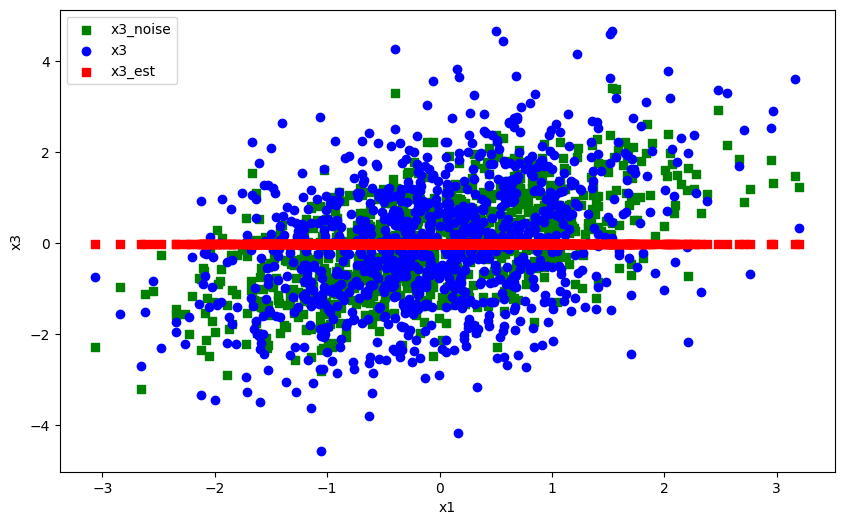

The programm is closed


In [89]:
np.random.seed(s)
n_samples = 1000 
dims=[d, 10, 1]
Sigma_truth = data["Sigma_truth"]
epsilon = np.random.multivariate_normal([0] * d, Sigma_truth, size=n_samples)
X_truth = data["X_truth"]
X_truth= torch.tensor(X_truth, dtype=torch.double)
X = X_truth - epsilon
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
fc1_weight_DAGMA = data["fc1_weight_DAGMA_end"]
fc1_bias_DAGMA = data["fc1_bias_DAGMA_end"]
fc2_weight_DAGMA = data["fc2_weight_DAGMA_end"]
fc2_bias_DAGMA = data["fc2_bias_DAGMA_end"]
copy_like_(eq_model.fc1.weight, fc1_weight_DAGMA)
copy_like_(eq_model.fc1.bias,   fc1_bias_DAGMA)
copy_like_(eq_model.fc2[0].weight, fc2_weight_DAGMA)
copy_like_(eq_model.fc2[0].bias, fc2_bias_DAGMA)
#eq_model.fc1.weight = fc1_weight_DAGMA
#eq_model.fc1.bias = fc1_bias_DAGMA
#eq_model.fc2[0].weight = fc2_weight_DAGMA
#eq_model.fc2[0].bias = fc2_bias_DAGMA
x_est=eq_model(X_truth)

plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_truth.detach().numpy()[:, 0], X_truth.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_truth.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')
plt.scatter(X_truth.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [90]:
X

tensor([[ 2.1198,  1.6905],
        [-0.6617, -1.8052],
        [-1.4952, -0.0615],
        ...,
        [-0.3758, -1.4092],
        [-1.1509,  0.9978],
        [ 0.6740, -0.3946]])

In [81]:
def forward(dims, fc1, fc2, mask, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of the sigmoidal feedforward NN

    Args:
        x (torch.Tensor): input

    Returns:
        torch.Tensor: output
    """
    # x = self.fc1(x) # [n, self.d * dims[1]]
    weight = fc1.weight*mask #[d * dims[1], d]
    x = x@(weight.T) 
    if fc1.bias is not None:
        x = x + fc1.bias.unsqueeze(0)

    x = x.view(-1, dims[0], dims[1]) # [n, d, self.dims[1]]

    # self.activation = nn.SiLU()
    activation = nn.Sigmoid()

    for fc in fc2:
        # x = torch.sigmoid(x)
        x = activation(x)
        x = fc(x) # [n, d, self.dims[2]]

    x = x.squeeze(dim=2) #[n, d]

    return x

def generate_layers(d, dims, admg, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    bias=True
    fc1 = nn.Linear(d, d * dims[1], bias=bias) # [d * dims[1], d]
    # self.fc1.weight.bounds = self._bounds()
    mask = torch.ones(d * dims[1], d)

    for j in range(d):
        allowed_parents = admg[j]['parents']
        not_parents = [p for p in range(d) if p not in allowed_parents]
        mask[j * dims[1]:(j + 1) * dims[1], not_parents] = 0.0 + 1e-6

    layers = []
    for l in range(len(dims) - 2):
        layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
    fc2 = nn.ModuleList(layers)
    return fc1, fc2, mask

def scale_weights(model, factor=10):
    with torch.no_grad():
        for param in model.parameters():
            if param.ndim > 1:  # Skip bias
                param.mul_(factor)

def generate_from_epsilon(dims, epsilon, fc1, fc2, mask, parents):
    """
    Generate data x from epsilon according to x = f(x_parents) + epsilon.
    
    Args:
        epsilon: [n, d] tensor of Gaussian noise
        fc1, fc2, mask: network parameters
        parents: dict {j: [parents_of_j]}
    Returns:
        x: [n, d] tensor of generated variables
    """
    n, d = epsilon.shape
    X = torch.zeros_like(epsilon)

    # Determine topological order (if not already given)
    order = list(parents.keys())  # assume already topologically sorted

    for j in order:
        if len(parents[j]) == 0:
            # root node: only noise
            X[:, j] = epsilon[:, j]
        else:
            # prepare partial input with parents filled
            x_partial = torch.zeros(n, d, dtype=epsilon.dtype)
            for p in parents[j]:
                x_partial[:, p] = X[:, p]

            # compute all f_j(x) in parallel, then pick j-th column
            f_out = forward(dims, fc1, fc2, mask, x_partial)  # [n, d]
            X[:, j] = f_out[:, j] + epsilon[:, j]

    return X

In [82]:
admg = data["admg"]
admg = {int(k): v for k, v in admg.items()}
parents = {j: admg[j]['parents'] for j in admg}
admg

{0: {'parents': [], 'spouses': [1]}, 1: {'parents': [], 'spouses': [0]}}

In [83]:
fc1, fc2, mask = generate_layers(d, dims, admg, seed = s)
scale_weights(fc1, factor=10)
for layer in fc2:
    scale_weights(layer, factor=15)
epsilon = torch.tensor(epsilon)
X_truth = generate_from_epsilon(dims, epsilon, fc1, fc2, mask, parents).detach()

In [84]:
epsilon

tensor([[-1.1530, -1.7224],
        [ 0.9668, -0.0319],
        [ 0.3052, -1.8371],
        ...,
        [ 0.3083,  0.4838],
        [-0.0675, -0.9254],
        [-1.2184,  0.0724]])

In [85]:
X = X_truth-epsilon
X

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])